# Simulation with critic

## Import

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import or_tools

from copy import deepcopy
from tqdm import tqdm

from environment import Environment
from actor import DenseActor, RandomActor
from critic import Critic
from utils import make_simulation_plot, make_simulation_plot_2, run_environment_simulation, calculate_full_distance

## Environment creation

In [18]:
# Set environment parameters
n_samples_train = 3000
n_samples_test = 10
n_locations = 5
n_steps = n_locations * 2 + 1
max_demand = 10
max_capacity = 50
n_epochs = 200
approximation_level = 100

# Initialize the actor and critic
dense_actor = DenseActor(n_locations)
random_actor = RandomActor(n_locations)
critic = Critic()
optimizer = tf.keras.optimizers.legacy.Adam()

# Separate environments for training and testing
env_org = Environment(n_samples_train, n_locations, max_demand, max_capacity)
env_test = Environment(n_samples_test, n_locations, max_demand, max_capacity)

## Initializing data structures for losses and actions taken

In [19]:
grads_lst = []
losses_train = []
losses_test = []
losses_test_random = []

critic_losses_train = []

# Real actions and approximation actions
# Real - means the actions that the actor takes
# Approximation - means the actions that is the output of the Neural Network
all_actions_real_train = []
all_actions_real_test = []
all_actions_real_random = []

all_actions_approximation_train = []
all_actions_approximation_test = []
all_actions_approximation_random = []

## Training loop

In [20]:
for _ in tqdm(range(n_epochs)):
    env_train_process = deepcopy(env_org)
    env_test_process = deepcopy(env_test)
    env_test_process_random = deepcopy(env_test)
    with tf.GradientTape(persistent=True) as tape:
        actions_approximation_train, actions_real_train = run_environment_simulation(
            env_train_process, dense_actor, n_steps, approximation_level
        )
        actions_approximation_test, actions_real_test = run_environment_simulation(
            env_test_process, dense_actor, n_steps, approximation_level
        )

        actions_approximation_test_random, actions_real_test_random = run_environment_simulation(
            env_test_process_random, random_actor, n_steps, approximation_level
        )

        actions_for_critic_train = tf.reshape(actions_approximation_train, (-1, n_samples_train))
        actions_for_critic_train = tf.transpose(actions_for_critic_train)
        critic_estimation_train = critic(env_train_process, tf.convert_to_tensor(actions_for_critic_train))

        full_distance_train = calculate_full_distance(tf.convert_to_tensor(actions_approximation_train))
        loss_train = tf.reduce_mean(full_distance_train)

        full_distance_test = calculate_full_distance(tf.convert_to_tensor(actions_approximation_test))
        loss_test = tf.reduce_mean(full_distance_test)

        full_distance_test_random = calculate_full_distance(tf.convert_to_tensor(actions_approximation_test_random))
        loss_test_random = tf.reduce_mean(full_distance_test_random)

        losses_train.append(loss_train)
        losses_test.append(loss_test)
        losses_test_random.append(loss_test_random)

        advantage_train = full_distance_train - critic_estimation_train
        loss_train_advantage = loss_train * advantage_train * 0.001
        loss_train_critic = advantage_train ** 2
        critic_losses_train.append(loss_train_critic)

    all_actions_approximation_train.append(actions_approximation_train)
    all_actions_approximation_test.append(actions_approximation_test)

    all_actions_real_train.append(actions_real_train)
    all_actions_real_test.append(actions_real_test)

    grads = tape.gradient(loss_train_advantage, dense_actor.trainable_variables)
    grads_and_vars = zip(grads, dense_actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)

    critic_grads = tape.gradient(loss_train_critic, critic.trainable_variables)
    critic_grads_and_vars = zip(critic_grads, critic.trainable_variables)
    optimizer.apply_gradients(critic_grads_and_vars)

100%|██████████| 200/200 [40:34<00:00, 12.17s/it]


In [21]:
tf_all_actions_approximation_train = tf.convert_to_tensor(all_actions_approximation_train)
tf_all_actions_approximation_test = tf.convert_to_tensor(all_actions_approximation_test)

tf_all_actions_real_train = tf.convert_to_tensor(all_actions_real_train)
tf_all_actions_real_test = tf.convert_to_tensor(all_actions_real_test)
# shape: [n_epochs x n_steps x n_samples x 2]

## Analysing the results

In [22]:
# Auxillary function that helps in visualization
def average_smoothing(ls, n):
    return [np.mean(ls[i : i + n]) for i in range(0, len(ls) - n)]

### Losses

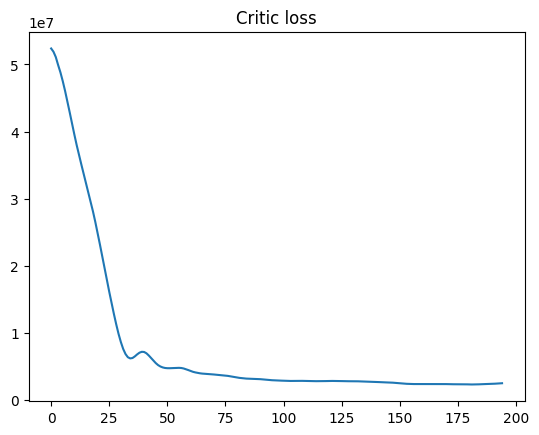

In [23]:
plt.plot(average_smoothing(critic_losses_train, 5))
plt.title("Critic loss")
plt.show()

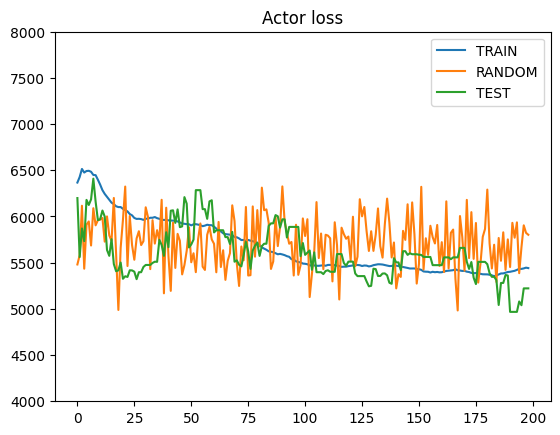

In [24]:
smoothing = 1
plt.plot(average_smoothing(losses_train, smoothing), label="TRAIN")
plt.plot(average_smoothing(losses_test_random, smoothing), label="RANDOM")
plt.plot(average_smoothing(losses_test, smoothing), label="TEST")
plt.legend()
plt.ylim([4000, 8000])
plt.title("Actor loss")
plt.show()

**Note**: Random shows the loss obtained by a dummy actor moving to each location by random choice. Although the decrease in the loss may not seem very significant, in fact when we look at the values we can observe that the finial loss is about 1000 less that loss at the beginning, while random actor score oscillates around the same value.

## Comparing results to the solution obtained via or_tools solver

### Get the or_tools solutions

In [25]:
results_or_tools = []
routes_or_tools = []

for i in range(n_samples_test):
    data_or_tools = or_tools.create_data_model(env_test, i)
    td, _, r = or_tools.or_tools_solve(data_or_tools)

    results_or_tools.append(td)
    routes_or_tools.append(r)

### Calculate distances obtained by the actor at the beginning and at the end of training

In [26]:
distances_0_epoch = calculate_full_distance(tf.convert_to_tensor(tf_all_actions_approximation_test)[0, :,])
distances_last_epoch = calculate_full_distance(tf.convert_to_tensor(tf_all_actions_approximation_test)[-1, :,])

### Assure that all of solutions have equal number of samples

In [27]:
assert len(results_or_tools) == n_samples_test
assert distances_0_epoch.shape == n_samples_test
assert distances_last_epoch.shape == n_samples_test

### Compare the results

In [28]:
print("OR TOOLS: ", f"{np.mean(results_or_tools)}")
print("0 EPOCH: ", f"{np.mean(distances_0_epoch)}")
print("LAST EPOCH: ", f"{np.mean(distances_last_epoch)}")

OR TOOLS:  4110.5
0 EPOCH:  6199.23974609375
LAST EPOCH:  5221.77001953125


**Note:** The results above tell that the or_tools solution is better than the last epoch solution, but the value obtained at the last epoch is significantly lower than the one at the beginning. In future with more computing power and using more complex computing power maybe it would be possible to approach the score of the or_tools solver.

### Checking specific samples

We want to check results obtained at the beginning of training, at the last epoch and compare them to the results obtained by the solver from or_tools.
The sample id can be changed.

In [29]:
sample_id = 2 # arbitrary sample id

### ORTools solution

3276


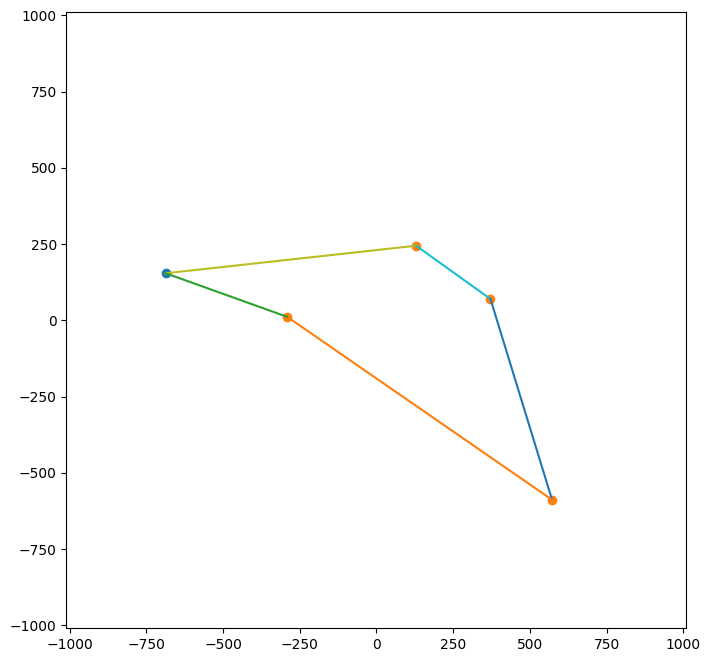

In [30]:
print(results_or_tools[sample_id])
flat_list = [x for xs in routes_or_tools[sample_id] for x in xs]
make_simulation_plot_2(env_test_process.locations[sample_id], flat_list)

### Test set - first epoch

5941.2397


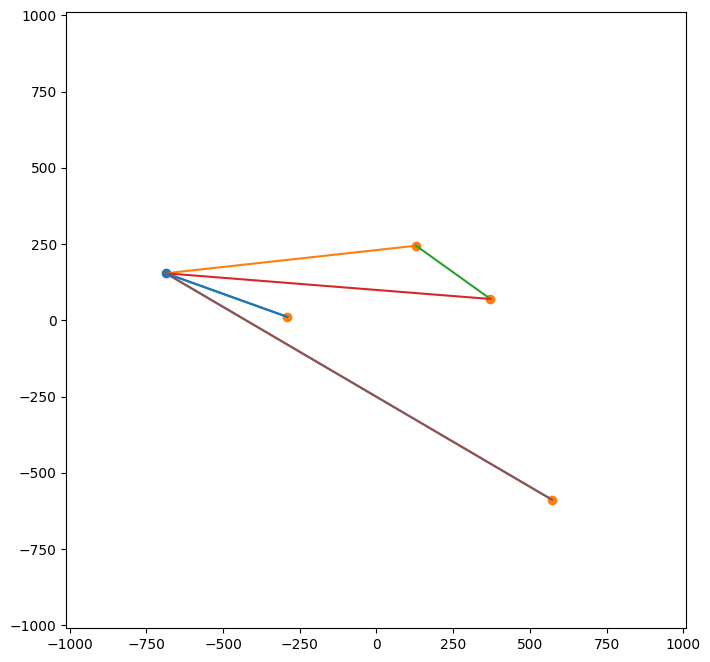

In [31]:
l1 = calculate_full_distance(tf.convert_to_tensor(tf_all_actions_approximation_test)[0, :, sample_id])
print(l1.numpy())
make_simulation_plot(env_test_process.locations[sample_id], tf_all_actions_real_test[0, :, sample_id])

### Test set - last epoch

3789.2273


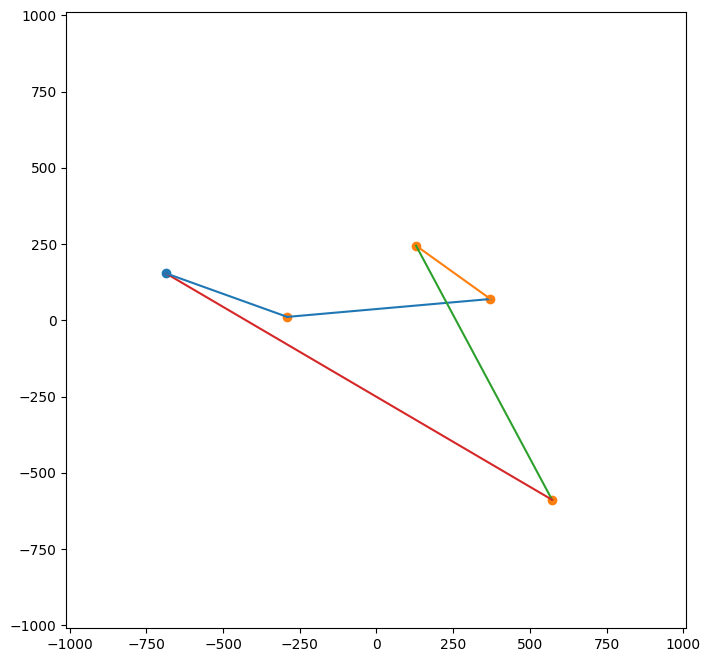

In [32]:
l1 = calculate_full_distance(tf.convert_to_tensor(tf_all_actions_approximation_test)[-1, :, sample_id])
print(l1.numpy())
make_simulation_plot(env_test_process.locations[sample_id], tf_all_actions_real_test[-1, :, sample_id])

### Conclusions:

As it was mentioned throughout this notebook the solution obtained with the usage of our RL model is not yet on par with the routes generated by the or_tools solver. Although we can observe that the created model is able to learn and improves its output over time. In the first epoch the vehicle returns to the depot almost after visiting each location while the last route is more similar to the one from or_tools. Having more time a probable next step would be trying longer training with more complex actors architectures, also a nice thing would be to try and compare some other approaches e.g. Pointer Networks listed in the link in README.